# Create the convective ABL case for NREL5MW runs

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil
import yaml

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
rundir = './'
originalinput = 'abl.inp'
outputfile    = '../input_files/convective_abl.inp'

In [4]:
# Load the starting point
# This assumes that rundir was already set up with setup.sh (see https://github.com/Exawind/exawind-cases/blob/main/16_turb_abl_fsi/setup.sh)
os.chdir(rundir)
case.loadAMRWindInput(originalinput)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('io.line_plot_int', '1'),
             ('CoriolisForcing.turn_off_vertical_force', 'True'),
             ('tagging.static_refinement', 'false'),
             ('tagging.static_refinement_def', 'static_box.txt')])

In [5]:
# Remove static refinement from the static_box.txt file
case.extradictparams.pop('tagging.static_refinement', None)
case.extradictparams.pop('tagging.static_refinement_def', None)

'static_box.txt'

In [6]:
# Set the tolerances to match other ABL runs
case.setAMRWindInput('diffusion.mg_rtol',  1.0e-8)
case.setAMRWindInput('diffusion.mg_atol',  1.0e-8)

case.setAMRWindInput('mac_proj.mg_rtol',   1.0e-8)
case.setAMRWindInput('mac_proj.mg_atol',   1.0e-8)

case.setAMRWindInput('nodal_proj.mg_rtol', 1.0e-8)
case.setAMRWindInput('nodal_proj.mg_atol', 1.0e-8)

case.setAMRWindInput('temperature_diffusion.mg_rtol', 1.0e-8)
case.setAMRWindInput('temperature_diffusion.mg_atol', 1.0e-8)

## Add a turbine

In [7]:
# This is a dummy turbine, just to get the dimensions of the turbine placement correct
turbinetype = case.get_default_turbinetypedict()
turbinetype['turbinetype_name'] = 'NREL5MW_junk'
turbinetype['Actuator_type']    = 'UniformCtDisk'
turbinetype['Actuator_rotor_diameter']     = 126.0
turbinetype['Actuator_hub_height']         = 90.0
turbinetype['Actuator_epsilon']            = [2.5]
turbinetype['Actuator_output_frequency']   = 1
turbinetype['Actuator_diameters_to_sample']= 5.0 
turbinetype['Actuator_num_points_r']       = 20
turbinetype['Actuator_num_points_t']       = 3
turbinetype['Actuator_thrust_coeff']       = 0.2
case.add_populatefromdict('listboxturbinetype', turbinetype)

In [8]:
# Build the CSV input file of turbine layouts for amrwind-frontend
options=""

turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T1,  1800, 1800, NREL5MW_junk, 240.0, , 
"""
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [9]:
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['T1']


## Add refinement regions (optional)

In [10]:
## Add refinement zones
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     2160,     2160,       2160,    90,   200,   center:specified units:meter orientation:x centerx:2560 centery:2560 centerz:90 name:level1
#1,     1600,     1600,       1600,    90,   200,   center:specified units:meter orientation:x centerx:2000 centery:2000 centerz:90 name:level2
0,     5,        10,         5,     0.75,   2,
1,     2.5,      5,          2,     0.75,   1.5,
2,     1.25,     2.0,        1.25,  0.75,   1.0, 
3,     0.75,     0.75,       1.00,  0.75,   0.75, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

# Uncomment this to create refinement zones
#case.refine_createAllZones()

In [11]:
case.estimateMeshSize()

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
  TOTAL:     50331648


## Add some sampling planes

In [12]:
# First delete everything that already exists
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [13]:
## virtual metmast measurements
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
case.add_postprosetup(metmastpprosetup, verbose=True)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'virtualmast'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 20
sampledict['sampling_l_start']      = [1800, 1800, 10.0]
sampledict['sampling_l_end']        = [1800, 1800, 200.0]
case.add_sampling(sampledict, verbose=False)

postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_derived_fields: None
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [14]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:100"
samplingcsv="""
# CSV file should have columns withturbinescsv
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2,  options
rotorplaneUP,  rotorplane, 4,     0,       2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneUP_  orientation:nacdir {outputoptions} noffsets:4
rotorplaneDN,  rotorplane, 0,     10,      2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneDN_  orientation:nacdir {outputoptions} noffsets:10
turbsw,      streamwise, 4,       10,      0,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:turbsw_        orientation:nacdir {outputoptions} noffsets:0
turbhh,      hubheight,  4,       10,      2,       0,    0,   11, 11,           usedx:0.05 outputto:turbhh_        orientation:nacdir {outputoptions} noffsets:0
XYdomain027, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_027_ orientation:nacdir center:specified centerx:100 centery:100 centerz:27 wholedomain:1  {outputoptions} noffsets:0
XYdomain090, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_090_ orientation:nacdir center:specified centerx:100 centery:100 centerz:90 wholedomain:1  {outputoptions} noffsets:0
XYdomain153, hubheight,  8,       8,       2,       0,    153, 11, 11, units:meter usedx:10 outputto:XYdomain_153_ orientation:nacdir center:specified centerx:100 centery:100 centerz:153 wholedomain:1  {outputoptions} noffsets:0
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [15]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['virtualmast', 'T1_rotorplaneUP', 'T1_rotorplaneDN', 'T1_turbsw', 'T1_turbhh', 'Farm_XYdomain027', 'Farm_XYdomain090', 'Farm_XYdomain153']


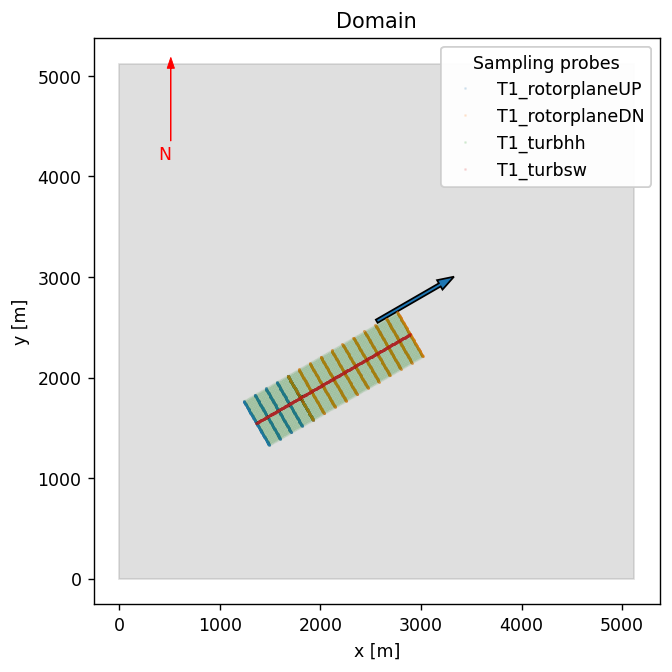

In [16]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['T1_rotorplaneUP', 'T1_rotorplaneDN', 'T1_turbhh', 'T1_turbsw',] #case.listboxpopupwindict['listboxsampling'].getitemlist() #['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.25, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

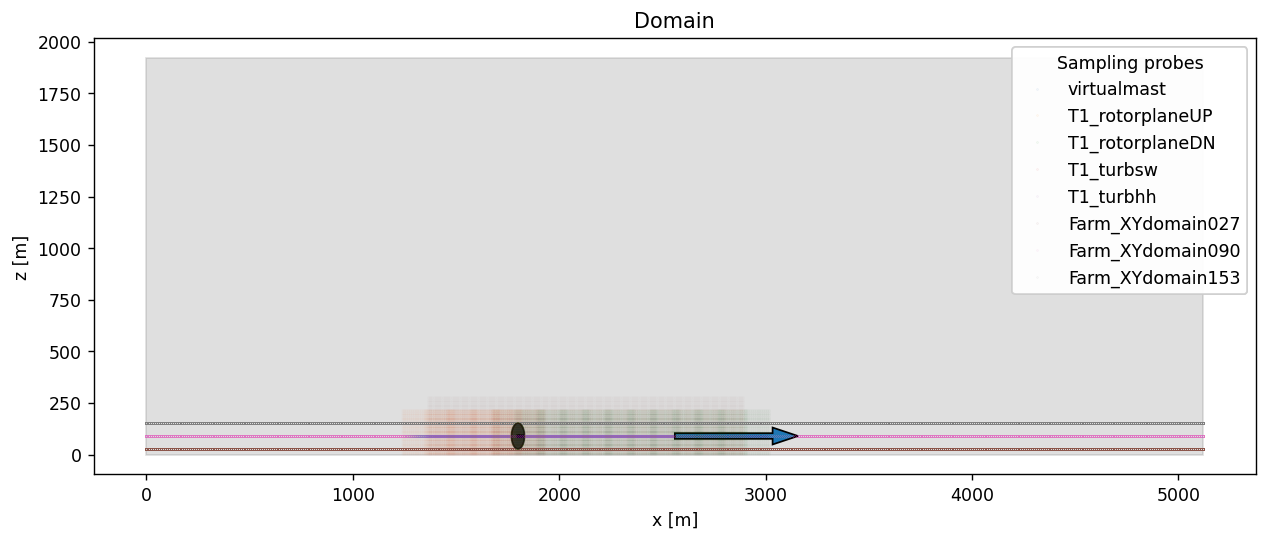

In [17]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() #['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview'] = 'XZ'
case.plotDomain(ax=ax)

In [18]:
case.removeturbines()

In [19]:
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 15000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-08               
nodal_proj.mg_atol             